In [1]:
!pip install emcee

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
import emcee

In [3]:
hdul1 = fits.open("C:/Users/Sara Trevisan/Downloads/SPT-CL_J2344-4243/SPT-CL_J2344-4243_band3_combined.dat.im.image.fits")
hdul2 = fits.open("C:/Users/Sara Trevisan/Downloads/SPT-CL_J2344-4243/SPT-CL_J2344-4243_band3_combined.jac.im.image.fits")

In [4]:
num_hdus = len(hdul1)
print(f"Numero di HDU nel file FITS: {num_hdus}")

data1 = hdul1[0].data
data2 = hdul2[0].data

print(f"Dimensioni dei dati: {data1.shape}")
print(f"Tipo di dati: {data1.dtype}")
print(f"Dimensioni dei dati 2: {data2.shape}")
print(f"Tipo di dati 2: {data2.dtype}")

Numero di HDU nel file FITS: 1
Dimensioni dei dati: (2048, 2048)
Tipo di dati: >f4
Dimensioni dei dati 2: (2048, 2048)
Tipo di dati 2: >f4


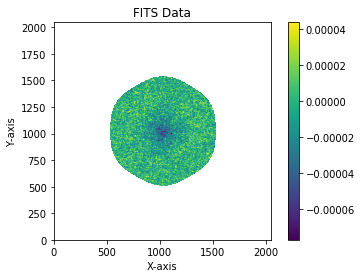

In [5]:
plt.imshow(data1, cmap='viridis', origin='lower')  
plt.colorbar()
plt.title('FITS Data')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()


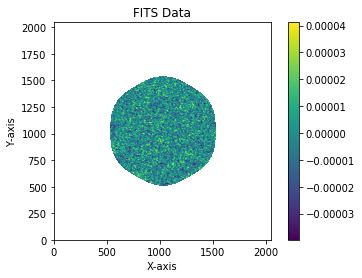

In [6]:
plt.imshow(data2, cmap='viridis', origin='lower')
plt.colorbar()
plt.title('FITS Data')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

In [7]:
#cerco fli estremi per le coordinate x e y 
valid_pixel_coordinates = np.argwhere(~np.isnan(data1))

x_coordinates = valid_pixel_coordinates[:, 1]
y_coordinates = valid_pixel_coordinates[:, 0]


min_x = np.min(x_coordinates)
max_x = np.max(x_coordinates)
min_y = np.min(y_coordinates)
max_y = np.max(y_coordinates)

print("Minimum X (with valid data):", min_x)
print("Maximum X (with valid data):", max_x)
print("Minimum Y (with valid data):", min_y)
print("Maximum Y (with valid data):", max_y)

Minimum X (with valid data): 528
Maximum X (with valid data): 1520
Minimum Y (with valid data): 510
Maximum Y (with valid data): 1538


In [8]:

data1 = hdul1[0].data # Dati associati effetto SZ
noise_estimate = hdul2[0].data # rumore associata 

x = np.arange(data1.shape[1])
y = np.arange(data1.shape[0]) 


fixed_beta = 0.8  

# guess iniziale 
initial_guess = [1000, 1000, 1.0, 500]

In [9]:
# maschero i nan value nelle immagini

nan_mask = np.isnan(data1)
nan_flag = np.zeros_like(data1, dtype=bool)
nan_flag[nan_mask] = True

data1_masked = np.ma.masked_array(data1, mask=nan_flag)


nan_mask2 = np.isnan(noise_estimate)
nan_flag2 = np.zeros_like(noise_estimate, dtype=bool)
nan_flag2[nan_mask2] = True

noise_estimate_masked = np.ma.masked_array(noise_estimate, mask=nan_flag2)


In [10]:
# definizione del modello 
def beta_model(params, x, y):
    x0, y0, normalization, rc = params
    beta = fixed_beta 
    r_squared = (x - x0)**2 + (y - y0)**2
    model = normalization * (1 + r_squared / rc**2)**(-3 * beta / 2)
    return model

In [11]:

def log_prior(params):
    x0, y0, normalization, rc = params
    # print("log_prior params:", params)
    # Define your priors here, e.g., uniform priors
    if min_x < x0 < max_x and min_y < y0 < max_y and 0 < normalization and 0 < rc < 500:
        return 0.0  
    return -np.inf 

In [13]:
# def log_likelihood(params, x, y, data1, noise_estimate):
#     model = beta_model(params, x, y)
#     residual = data1 - model
#     noise_estimate += 1e-10
#     logl = np.sum(np.log(1. / np.sqrt(2 * np.pi * noise_estimate**2)) - (residual**2) / (2. * noise_estimate**2))
#     print("logl:", logl)
#     return logl
def log_likelihood(params, x, y, data1, noise_estimate):
    model = beta_model(params, x, y)
    residual = data1 - model
    logl = np.sum(-0.5 * np.log(2 * np.pi * noise_estimate**2) - 0.5 * (residual**2) / noise_estimate**2)
    # print("logl:", logl)
    return logl

In [14]:
def log_posterior(params, x, y, data1, noise_estimate):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    logl = log_likelihood(params, x, y, data1, noise_estimate)

    # print("logl:", logl)
    # print("lp:", lp)

    logpos = logl + lp
    return logpos # , lp, logl


In [15]:
# Definisco il numero di parametri e di walkers 
nwalkers, ndim = 16, 4

pos = [initial_guess] + 1e-2 * np.random.randn(nwalkers, ndim)

In [16]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x, y, data1_masked, noise_estimate_masked))

In [ ]:
# Run the MCMC sampler
n_steps = 2000
sampler.run_mcmc(pos, n_steps, progress=True)

  0%|                                                                                         | 0/2000 [00:00<?, ?it/s]C:\Users\Sara Trevisan\Anaconda3\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 93%|█████████████████████████████████████████████████████████████████████▍     | 1853/2000 [12:54:41<16:36,  6.78s/it]

In [ ]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
print(samples.shape)
labels = ["x_0", "y_0", "normalization", "rc"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [ ]:
tau = sampler.get_autocorr_time()
print(tau)

In [ ]:
flat_samples = sampler.get_chain(discard=100, flat=True)
flat_blob = sampler.get_blobs(flat=True,discard=100)

print(flat_samples.shape, flat_blob.shape)

Max_likelihood=np.argmax(flat_blob[:,1])
print(flat_samples[Max_likelihood,:])

In [ ]:
import corner
fig = corner.corner(flat_samples, labels=labels)

In [ ]:
import pygtc
GTC = pygtc.plotGTC(chains=flat_samples,paramNames=labels,figureSize=7,holdRC=True,
                    customLabelFont={'size':14},customTickFont={'size':14}, truths=flat_samples[Max_likelihood,:])